# 1. Setup

### 1.1 Install Dependencies & GPU Setup

In [ ]:
!pip install tensorflow tensorflow-gpu tensorflow_hub opencv-python matplotlib

In [ ]:
!pip install scipy

In [ ]:
!pip list

In [2]:
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import load_model

In [2]:
# Avoid OOM error. Setting GPU memory consumtion growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# path to our data folder
data_dir = 'data'

### 1.2 Remove Unwanted Images

In [ ]:
import cv2

# allow to check file extensions for our images:
import imghdr

In [ ]:
# change images in webp format to jpg

for img_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, img_class)):
        img_path = os.path.join(data_dir, img_class, image)
        f_name, f_ext = os.path.splitext(img_path)
        if f_ext == '.webp':
            new_name = f'{f_name}{".jpg"}'
            os.rename(img_path, new_name)

In [ ]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
# remove if extension not in exts and alert if problems

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image) 
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image {image_path} not in ext list')
                os.remove(image_path)
        except:
            print(f'Issue with image {image_path}')

# 2. Data Loading

### 2.1 Load Data

* We need two different generators because we don't want to do data augmentation to the validation set. 
* The same validation split has to be set in both of the generators. 
* To make sure randomization is the same for the training and validation splits, we use "seed".

In [4]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2
)   

In [5]:
train = datagen_train.flow_from_directory(
    data_dir,
    seed=42,
    target_size=(256, 256),
    shuffle=True,
    batch_size=64,
    subset='training')

val = datagen_val.flow_from_directory(
    data_dir,
    seed=42,
    target_size=(256, 256), 
    shuffle=True,
    batch_size=64,
    subset='validation')

Found 4439 images belonging to 8 classes.
Found 1106 images belonging to 8 classes.


# 3. Deep Learning Model

### 3.1 Building the Model

In [6]:
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD

In [7]:
model_url = "https://tfhub.dev/google/bit/m-r101x1/1"
module = hub.KerasLayer(model_url)

In [8]:
class MyBiTModel(tf.keras.Model):

    def __init__(self, num_classes, module):
        super().__init__()

        self.num_classes = num_classes
        self.head = Dense(num_classes, kernel_initializer='zeros', activation='softmax')
        self.bit_model = module
        self.dense1 = Dense(256, activation='relu')
        self.dropout = Dropout(0.3)

    def call(self, images):
        out = self.bit_model(images)
        out = self.dense1(out)
        out = self.dropout(out)
        out = self.head(out)
        return out

model = MyBiTModel(num_classes=8, module=module)

In [9]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### 3.2 Training

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.5,
                              min_delta=0.001,
                              mode = 'min',
                              patience = 3
                             )

In [11]:
# launch training

hist = model.fit(train, epochs=30, validation_data=val, batch_size=64, callbacks=[reduce_lr])

Epoch 1/30
17/70 [======>.......................] - ETA: 1:29 - loss: 1.5944 - accuracy: 0.3704

C:\Users\Usuario\Desktop\vehicle_classifier\vehicle_class\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


70/70 [==============================] - 174s 2s/step - loss: 1.1717 - accuracy: 0.5337 - val_loss: 0.7946 - val_accuracy: 0.6926 - lr: 0.0050
Epoch 2/30
70/70 [==============================] - 143s 2s/step - loss: 0.8842 - accuracy: 0.6601 - val_loss: 0.7409 - val_accuracy: 0.7188 - lr: 0.0050
Epoch 3/30
70/70 [==============================] - 199s 3s/step - loss: 0.8409 - accuracy: 0.6862 - val_loss: 0.7586 - val_accuracy: 0.7016 - lr: 0.0050
Epoch 4/30
70/70 [==============================] - 212s 3s/step - loss: 0.8259 - accuracy: 0.6878 - val_loss: 0.6941 - val_accuracy: 0.7351 - lr: 0.0050
Epoch 5/30
70/70 [==============================] - 238s 3s/step - loss: 0.7954 - accuracy: 0.7033 - val_loss: 0.7403 - val_accuracy: 0.6971 - lr: 0.0050
Epoch 6/30
70/70 [==============================] - 224s 3s/step - loss: 0.7688 - accuracy: 0.7144 - val_loss: 0.6630 - val_accuracy: 0.7468 - lr: 0.0050
Epoch 7/30
70/70 [==============================] - 242s 3s/step - loss: 0.7443 - accur

### 3.3 Plot Performance

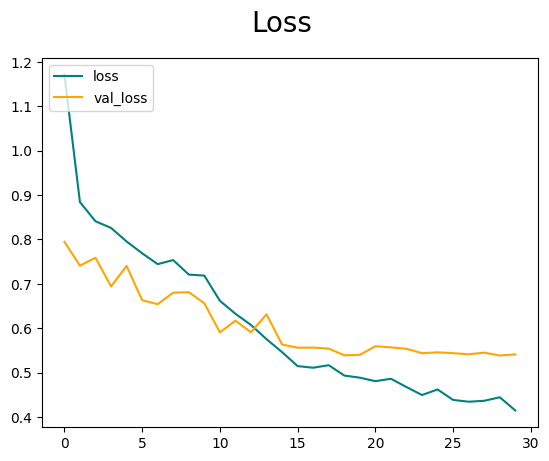

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

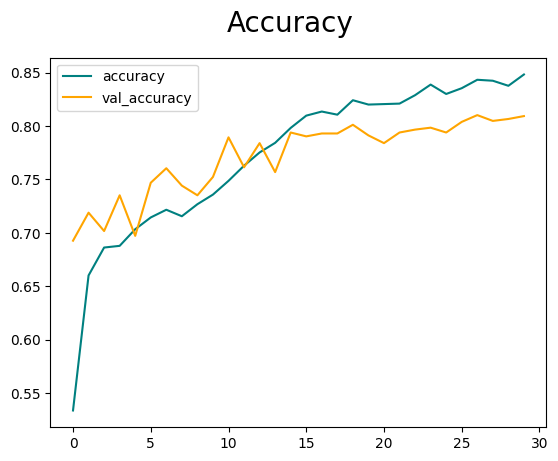

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4. Evaluate Performance

### 4.1 Evaluate

In [99]:
test_dir = 'test_data'

In [100]:
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
)   

In [101]:
test = datagen_test.flow_from_directory(
    test_dir,
    target_size=(256, 256), 
    batch_size=1,
    shuffle = False
)

Found 640 images belonging to 8 classes.


In [102]:
nr_samples = test.samples
predict = model.predict(test, steps = nr_samples)

640/640 [==============================] - 67s 104ms/step


In [117]:
correct_prediction = 0

for i in range(nr_samples):
    if np.argmax(predict[i]) == test.classes[i]:
        correct_prediction += 1

test_acc = correct_prediction / nr_samples

In [118]:
test_acc

0.7546875

### 4.2 Test

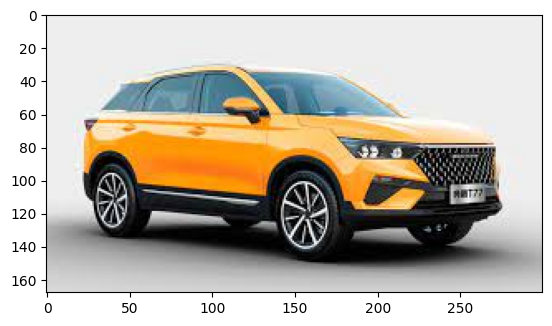

In [4]:
image = 'download (1).jfif'
manual_test_dir = 'images_to_test_manually'
image_path = os.path.join(manual_test_dir, image)

img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
resize = tf.image.resize(img, (256, 256))
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 9s 9s/step


In [7]:
top_result = np.argmax(yhat[0])
if top_result == 0:
    print(f'convertible {round(np.max(yhat[0])*100, 1)}%')
elif top_result == 1:
    print(f'coupe {round(np.max(yhat[0])*100, 1)}%')
elif top_result == 2:
    print(f'hatchback {round(np.max(yhat[0])*100, 1)}%')
elif top_result == 3:
    print(f'pickup {round(np.max(yhat[0])*100, 1)}%')
elif top_result == 4:
    print(f'sedan {round(np.max(yhat[0])*100, 1)}%')
elif top_result == 5:
    print(f'sport {round(np.max(yhat[0])*100, 1)}%')
elif top_result == 6:
    print(f'suv {round(np.max(yhat[0])*100, 1)}%')
elif top_result == 7:
    print(f'van_minivan {round(np.max(yhat[0])*100, 1)}%')

suv 63.7%


In [23]:
for k, v in zip(yhat[0], ["0-convertible" , "1-coupe" , "2-hatchback" , "3-pickup" , "4-sedan" , "5-sport", "6-suv", "7-van_minivan"]):
        print(f"{v}: {float(k):.3f}")

0-convertible: 0.001
1-coupe: 0.000
2-hatchback: 0.317
3-pickup: 0.004
4-sedan: 0.026
5-sport: 0.000
6-suv: 0.637
7-van_minivan: 0.016


# 5. Save the Model

### 5.1 Save the Model

In [15]:
model.save(os.path.join('models', 'vehicle_classifier_model.tf'))

INFO:tensorflow:Assets written to: models\vehicle_classifier_model.tf\assets


INFO:tensorflow:Assets written to: models\vehicle_classifier_model.tf\assets


### 5.2 Load the Model

In [5]:
model = load_model(os.path.join('models', 'vehicle_classifier_model.tf'))